In [17]:
# Import required libraries
import os
import pickle
import json
import numpy as np
from itertools import product
from sklearn.metrics import precision_recall_curve, auc
from run import symbol_detection_pipeline


In [18]:
# Load templates and reference colors
pickle_path = "data/templates.pkl"

with open(pickle_path, "rb") as f:
    reference_colors, all_templates, color_template_freq = pickle.load(f)

print(f"Loaded {len(all_templates)} templates")
print(f"Reference colors shape: {np.array(reference_colors).shape}")


Loaded 24 templates
Reference colors shape: (4, 3)


In [19]:
# Load ground truth
with open("data/groundtruth.json", "r") as f:
    ground_truth = json.load(f)

print(f"Ground truth loaded for {len(ground_truth)} images")
print("Sample ground truth:", dict(list(ground_truth.items())[:3]))


Ground truth loaded for 50 images
Sample ground truth: {'positive_00000.jpeg': ['GHS_00012', 'GHS_00017'], 'positive_00001.jpeg': ['GHS_00016'], 'positive_00002.jpeg': ['GHS_00012']}


In [20]:
# Get list of test images
image_dir = "data/images/"
test_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
test_images.sort()

print(f"Found {len(test_images)} test images")
print("Test images:", test_images[:5], "...")

assert len(test_images) == len(ground_truth)

Found 50 test images
Test images: ['positive_00000.jpeg', 'positive_00001.jpeg', 'positive_00002.jpeg', 'positive_00003.jpeg', 'positive_00004.jpeg'] ...


In [21]:
# Define parameter grids (all except ncc_threshold)
param_grid = {
    'rgb_threshold': [0.3], 
    'black_val_threshold': [50], 
    'white_sat_threshold': [0.1], 
    'white_val_threshold': [100], 
    'min_line_length_percent': [0.03], 
    'adjacency_radius': [6], 
    'dedup_thresh': [100], 
    'scale': [2],
    'num_octaves': [4], 
    'angle_tolerance': [5], 
    'distance_tolerance': [2] 
}

# NCC threshold range 
ncc_thresholds = np.arange(0, 1, 0.1) 

print("Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nNCC thresholds: {ncc_thresholds}")

# Calculate total number of experiments
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal parameter combinations: {total_combinations}")
print(f"Total experiments (with NCC variations): {total_combinations * len(ncc_thresholds)}")


Parameter grid:
  rgb_threshold: [0.3]
  black_val_threshold: [50]
  white_sat_threshold: [0.1]
  white_val_threshold: [100]
  min_line_length_percent: [0.03]
  adjacency_radius: [6]
  dedup_thresh: [100]
  scale: [2]
  num_octaves: [4]
  angle_tolerance: [5]
  distance_tolerance: [2]

NCC thresholds: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

Total parameter combinations: 1
Total experiments (with NCC variations): 10


In [22]:
# Helper function to extract template names from results
def extract_template_names(results, ncc_threshold):
    """Extract template names from pipeline results"""
    if 'matches' not in results:
        return []
    return [match['template_name'] for match in results['matches'] if match['ncc_score'] > ncc_threshold]


In [ ]:
# Helper function to compute precision and recall for a single image
def compute_precision_recall(predicted_templates, ground_truth_templates):
    """Compute precision and recall for a single image"""
    if not predicted_templates and not ground_truth_templates:
        return 1.0, 1.0 
    if not predicted_templates:
        return 1.0, 0.0 
    if not ground_truth_templates:
        return 0.0, 1.0
    
    predicted_set = set(predicted_templates)
    ground_truth_set = set(ground_truth_templates)
    
    true_positives = len(predicted_set.intersection(ground_truth_set))
    
    precision = true_positives / len(predicted_set) if predicted_set else 0.0
    recall = true_positives / len(ground_truth_set) if ground_truth_set else 0.0
    
    return precision, recall

# Helper function to compute F1 score
def compute_f1_score(precision, recall):
    """Compute F1 score from precision and recall"""
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


In [41]:
# Helper function to evaluate a single experiment across all NCC thresholds
def evaluate_experiment(params, experiment_id):
    """Evaluate a single parameter combination across all NCC thresholds"""
    print(f"\n=== Experiment {experiment_id} ===")
    print(f"Parameters: {params}")
    
    precision_scores = [[] for _ in ncc_thresholds]
    recall_scores = [[] for _ in ncc_thresholds]
      
    for img_idx, image_name in enumerate(test_images):
        if img_idx % 5 == 0: 
            print(f"    Processing image {img_idx+1}/{len(test_images)}: {image_name}")
        
        image_path = os.path.join(image_dir, image_name)
        ground_truth_templates = ground_truth.get(image_name, [])
        
        try:
            results = symbol_detection_pipeline(
                image_path=image_path,
                templates=all_templates,
                reference_colors=reference_colors,
                color_template_freq=color_template_freq,
                ncc_threshold=0.0,
                **params
            )

            for ncc_threshold_idx, ncc_threshold in enumerate(ncc_thresholds):
                print(f"    NCC threshold {ncc_threshold:.2f}")
                
                predicted_templates = extract_template_names(results, ncc_threshold)
                precision, recall = compute_precision_recall(predicted_templates, ground_truth_templates)
                
                precision_scores[ncc_threshold_idx].append(precision)
                recall_scores[ncc_threshold_idx].append(recall)
                

        except Exception as e:
            print(f"    Error processing {image_name}: {e}")
            
            for ncc_threshold_idx in range(len(ncc_thresholds)):
                precision_scores[ncc_threshold_idx].append(0.0)
                recall_scores[ncc_threshold_idx].append(0.0)
            

    avg_precisions = [np.mean(scores) for scores in precision_scores]
    avg_recalls = [np.mean(scores) for scores in recall_scores]
    
    for ncc_threshold_idx, ncc_threshold in enumerate(ncc_thresholds):
        print(f"    NCC threshold {ncc_threshold:.2f}: Avg Precision: {avg_precisions[ncc_threshold_idx]:.3f}, Avg Recall: {avg_recalls[ncc_threshold_idx]:.3f}")
    
    # Compute AUPRC (Area Under Precision-Recall Curve)
    sorted_indices = np.argsort(avg_recalls)
    sorted_recalls = np.array(avg_recalls)[sorted_indices]
    sorted_precisions = np.array(avg_precisions)[sorted_indices]

    # add the point (1, 0) to the sorted_recalls and sorted_precisions
    sorted_recalls = np.concatenate([sorted_recalls, [1]])
    sorted_precisions = np.concatenate([sorted_precisions, [0]])
    
    auprc = auc(sorted_recalls, sorted_precisions)
    
    print(f"  AUPRC: {auprc:.4f}")
    
    return {
        'experiment_id': experiment_id,
        'parameters': params,
        'ncc_thresholds': ncc_thresholds.tolist(),
        'precision_scores': avg_precisions,
        'recall_scores': avg_recalls,
        'auprc': auprc,
    }


In [42]:
# Main grid search execution
print("Starting grid search...")
print(f"Total combinations to evaluate: {total_combinations}")

results_list = []
experiment_id = 0

# Generate all parameter combinations
param_names = list(param_grid.keys())
param_values = list(param_grid.values())

from tqdm import tqdm

for combination in tqdm(list(product(*param_values)), total=total_combinations, desc="Grid Search Experiments"):
    experiment_id += 1

    params = dict(zip(param_names, combination))

    experiment_result = evaluate_experiment(params, experiment_id)
    results_list.append(experiment_result)

print(f"\nGrid search completed! Evaluated {len(results_list)} experiments.")


Starting grid search...
Total combinations to evaluate: 1


Grid Search Experiments:   0%|          | 0/1 [00:00<?, ?it/s]


=== Experiment 1 ===
Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}
    Processing image 1/50: positive_00000.jpeg
Time taken to load image: 0.0427241325378418 seconds
Time taken to get 6 color masks: 0.14223814010620117 seconds
Found 2718 segments over all masks
Post-processing mask 0
Found 104 segments after merging
Found 40 loops
Found 4 quads
Post-processing mask 1
Found 59 segments after merging
Found 1 loops
Found 0 quads
Post-processing mask 2
Found 23 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 3
Found 798 segments after merging
Found 58 loops
Found 0 quads
Post-processing mask 4
Found 377 segments after merging
Found 33 loops
Found 0 quads
Post-processing mask 5
Found 724 segments after merging
Found 74 loops
Found 2 quads
Foun

/Users/frbuccoliero/Desktop/Thesis/Tests/final_pipeline/run.py:141: RuntimeWarning: overflow encountered in scalar multiply
  return ab[0]*bc[1] - ab[1]*bc[0]


Time taken to get 6 color masks: 0.1003568172454834 seconds
Found 462 segments over all masks
Post-processing mask 0
Found 99 segments after merging
Found 24 loops
Found 2 quads
Post-processing mask 1
Found 0 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 2
Found 0 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 3
Found 121 segments after merging
Found 29 loops
Found 0 quads
Post-processing mask 4
Found 10 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 5
Found 122 segments after merging
Found 12 loops
Found 2 quads
Found 4 quads over all masks before deduplication
Found 1 quads over all masks after deduplication
Time taken to get 1 quads: 0.3513462543487549 seconds
Checking candidate 0
** Found GHS_00000 with NCC score 0.5811322927474976 **
** Found GHS_00009 with NCC score 0.6054189801216125 **
** Found GHS_00012 with NCC score 0.6285292506217957 **
** Found GHS_00013 with NCC score 0.6634401082992554 **
** Foun

Grid Search Experiments: 100%|██████████| 1/1 [00:32<00:00, 32.79s/it]

** Found GHS_00012 with NCC score 0.9331892132759094 **
** Found GHS_00013 with NCC score 0.8574302196502686 **
** Found GHS_00014 with NCC score 0.8179867267608643 **
** Found GHS_00015 with NCC score 0.8870834708213806 **
** Found GHS_00016 with NCC score 0.7827247977256775 **
** Found GHS_00017 with NCC score 0.8215394616127014 **
** Found GHS_00018 with NCC score 0.7701619863510132 **
** Found GHS_00019 with NCC score 0.6618369817733765 **
** Found GHS_00020 with NCC score 0.8460670113563538 **
Found 2 matches
Time taken to get 2 matches: 0.0985558032989502 seconds
Time taken to run pipeline: 0.5403931140899658 seconds
    NCC threshold 0.00
    NCC threshold 0.10
    NCC threshold 0.20
    NCC threshold 0.30
    NCC threshold 0.40
    NCC threshold 0.50
    NCC threshold 0.60
    NCC threshold 0.70
    NCC threshold 0.80
    NCC threshold 0.90
    NCC threshold 0.00: Avg Precision: 0.820, Avg Recall: 0.873
    NCC threshold 0.10: Avg Precision: 0.820, Avg Recall: 0.873
    NCC thr

0.8524666666666667


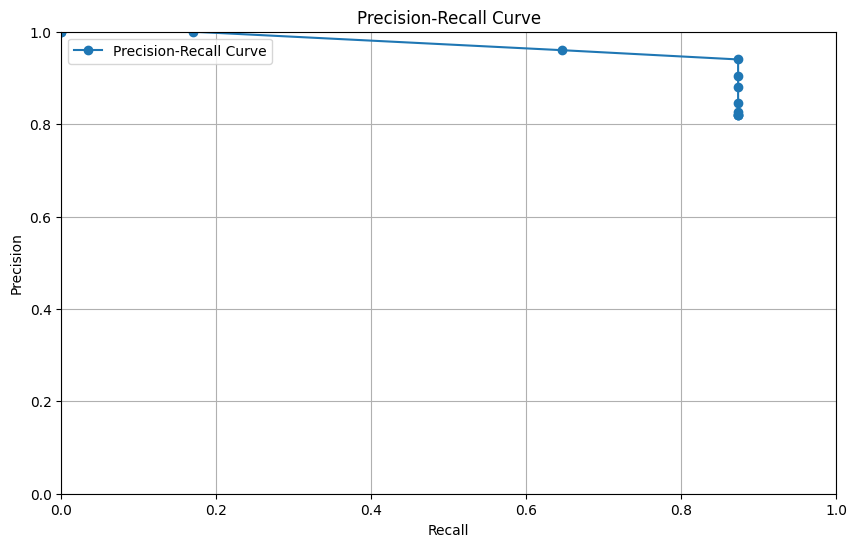

In [ ]:
# plot the auprc for the last result

precisions = results_list[-1]['precision_scores']
recalls = results_list[-1]['recall_scores']

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='o', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Analyze results
print("\n=== RESULTS SUMMARY ===")

# Sort results by AUPRC
sorted_results = sorted(results_list, key=lambda x: x['auprc'], reverse=True)

print(f"\nTop 5 experiments by AUPRC:")
for i, result in enumerate(sorted_results[:5]):
    print(f"{i+1}. Experiment {result['experiment_id']}: AUPRC = {result['auprc']:.4f}")
    print(f"   Parameters: {result['parameters']}")

print(f"\nWorst 5 experiments by AUPRC:")
for i, result in enumerate(sorted_results[-5:]):
    print(f"{len(sorted_results)-4+i}. Experiment {result['experiment_id']}: AUPRC = {result['auprc']:.4f}")
    print(f"   Parameters: {result['parameters']}")

# Statistics
auprc_scores = [r['auprc'] for r in results_list]
print(f"\nAUPRC Statistics:")
print(f"  Mean: {np.mean(auprc_scores):.4f}")
print(f"  Std:  {np.std(auprc_scores):.4f}")
print(f"  Min:  {np.min(auprc_scores):.4f}")
print(f"  Max:  {np.max(auprc_scores):.4f}")

# Per-image analysis across all experiments
print(f"\n=== PER-IMAGE PERFORMANCE ANALYSIS ===")

# Collect F1 scores for each image across all experiments
image_f1_across_experiments = {image_name: [] for image_name in test_images}

for result in results_list:
    for image_name, avg_f1 in result['avg_f1_per_image'].items():
        image_f1_across_experiments[image_name].append(avg_f1)

# Compute statistics for each image
image_f1_stats = {}
for image_name, f1_scores in image_f1_across_experiments.items():
    image_f1_stats[image_name] = {
        'mean': np.mean(f1_scores),
        'std': np.std(f1_scores),
        'min': np.min(f1_scores),
        'max': np.max(f1_scores)
    }

# Sort images by average performance across all experiments
sorted_images_overall = sorted(image_f1_stats.items(), key=lambda x: x[1]['mean'], reverse=True)

print(f"\nOverall best performing images (across all experiments):")
for i, (image_name, stats) in enumerate(sorted_images_overall[:10]):
    print(f"{i+1}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f} (range: {stats['min']:.3f}-{stats['max']:.3f})")

print(f"\nOverall worst performing images (across all experiments):")
for i, (image_name, stats) in enumerate(sorted_images_overall[-10:]):
    rank = len(sorted_images_overall) - 4 + i
    print(f"{rank}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f} (range: {stats['min']:.3f}-{stats['max']:.3f})")

# Find most consistent and most variable images
sorted_by_std = sorted(image_f1_stats.items(), key=lambda x: x[1]['std'])
print(f"\nMost consistent images (lowest F1 standard deviation):")
for i, (image_name, stats) in enumerate(sorted_by_std[:3]):
    print(f"{i+1}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f}")

print(f"\nMost variable images (highest F1 standard deviation):")
for i, (image_name, stats) in enumerate(sorted_by_std[-3:]):
    rank = len(sorted_by_std) - 2 + i
    print(f"{rank}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f}")



=== RESULTS SUMMARY ===

Top 5 experiments by AUPRC:
1. Experiment 1: AUPRC = 0.3704
   Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}

Worst 5 experiments by AUPRC:
-3. Experiment 1: AUPRC = 0.3704
   Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}

AUPRC Statistics:
  Mean: 0.3704
  Std:  0.0000
  Min:  0.3704
  Max:  0.3704

=== PER-IMAGE PERFORMANCE ANALYSIS ===

Overall best performing images (across all experiments):
1. positive_00025.jpeg: Mean F1 = 1.000 ± 0.000 (range: 1.000-1.000)
2. positive_00034.jpeg: Mean F1 = 1.000 ± 0.000 (range

In [ ]:
# Detailed analysis of best experiment
if results_list:
    print("\n=== DETAILED ANALYSIS OF BEST EXPERIMENT ===")
    
    best_experiment = sorted_results[0]
    print(f"Best Experiment #{best_experiment['experiment_id']} (AUPRC: {best_experiment['auprc']:.4f})")
    print(f"Parameters: {best_experiment['parameters']}")
    
    # Show F1 scores for each image in the best experiment
    best_exp_image_f1 = best_experiment['avg_f1_per_image']
    sorted_best_exp_images = sorted(best_exp_image_f1.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nPer-image F1 scores in best experiment:")
    for i, (image_name, f1_score) in enumerate(sorted_best_exp_images):
        gt_templates = ground_truth.get(image_name, [])
        print(f"  {i+1:2d}. {image_name}: F1 = {f1_score:.3f} (Ground truth: {gt_templates})")
    
    # Show performance across NCC thresholds for the best and worst image
    if sorted_best_exp_images:
        best_image = sorted_best_exp_images[0][0]
        worst_image = sorted_best_exp_images[-1][0]
        
        print(f"\nF1 scores across NCC thresholds for best image ({best_image}):")
        best_image_f1_scores = best_experiment['per_image_f1_scores'][best_image]
        for i, (ncc_thresh, f1) in enumerate(zip(ncc_thresholds, best_image_f1_scores)):
            print(f"  NCC {ncc_thresh:.2f}: F1 = {f1:.3f}")
        
        print(f"\nF1 scores across NCC thresholds for worst image ({worst_image}):")
        worst_image_f1_scores = best_experiment['per_image_f1_scores'][worst_image]
        for i, (ncc_thresh, f1) in enumerate(zip(ncc_thresholds, worst_image_f1_scores)):
            print(f"  NCC {ncc_thresh:.2f}: F1 = {f1:.3f}")
else:
    print("No results to analyze.")



=== DETAILED ANALYSIS OF BEST EXPERIMENT ===
Best Experiment #1 (AUPRC: 0.6707)
Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}

Per-image F1 scores in best experiment:
   1. positive_00024.jpeg: F1 = 1.000 (Ground truth: [])
   2. positive_00025.jpeg: F1 = 1.000 (Ground truth: ['GHS_00014'])
   3. positive_00000.jpeg: F1 = 0.967 (Ground truth: ['GHS_00012', 'GHS_00017'])
   4. positive_00002.jpeg: F1 = 0.900 (Ground truth: ['GHS_00012'])
   5. positive_00010.jpeg: F1 = 0.900 (Ground truth: ['GHS_00014'])
   6. positive_00016.jpeg: F1 = 0.900 (Ground truth: ['GHS_00014'])
   7. positive_00019.jpeg: F1 = 0.900 (Ground truth: ['GHS_00014', 'GHS_00016'])
   8. positive_00020.jpeg: F1 = 0.900 (Ground truth: ['GHS_00017'])
   9. positive_00027.jpeg: F1 = 0.900 (Ground t

In [ ]:
# Save results to file
output_file = "grid_search_results.json"

with open(output_file, 'w') as f:
    json.dump(results_list, f, indent=2)

print(f"\nResults saved to {output_file}")
print(f"Total experiments saved: {len(results_list)}")



Results saved to grid_search_results.json
Total experiments saved: 1
